In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.interpolate import interp1d
from scipy.integrate import quad, simps

In [27]:
try:
    os.mkdir('figures')
except:
    pass    

In [28]:
# Unidades
m = 1
kg = 1
s = 1
deg = np.pi / 180

cm = 1e-2 * m
km = 1e3 * m

g = 1e-3 * kg
J = kg * m**2 / s**2
ergio = 1e-7 * J

Mton = 4.18e15 * J

au = 1.496e11 * m
day = 60 * 60 * 24 * s

In [29]:
# Constantes
mu_0 = 1.255e-6 # Permeabilidad del vacío
k_B = 1.38064852e-23 # Constante de Boltzmann
G = 6.67430e-11 # Gravitatoria

M_o = 1.989e30 # Masa del sol
m_p = 1.67e-27 # Masa del proton

In [30]:
planets_data = pd.read_csv('planets_data.csv', index_col=0)
planets_data

,scale_factor,Sun,Earth,Jupiter,Saturn,Uranus,Neptune
mass,1.000000e+24,1989100.0,5.97,1898.0,568,86.8,102
diameter,1.000000e+03,1391016.0,12756.00,142984.0,120536,51118.0,49528
M,7.906000e+22,NaN,1.00,20000.0,600,50.0,25
a,1.000000e+09,0.0,149.60,778.5,1432,2867.0,4515


In [31]:
class Body:
    def __init__(self, name) :
        self.name = name
        self.data = planets_data[name]
        
        for key, value in self.data.items():
            setattr(self, key, value * planets_data["scale_factor"][key])

        self.radius = self.diameter / 2

Sun = Body('Sun')
Earth = Body('Earth')
Jupiter = Body('Jupiter')
Saturn = Body('Saturn')
Uranus = Body('Uranus')
Neptune = Body('Neptune')

planets = [Jupiter, Saturn, Uranus, Neptune]


In [7]:
cientific_notation = lambda x: "{:.2e}".format(x)
cientific_notation = lambda x, cifras = 2: "{:.{cifras}e}".format(x, cifras=cifras)

# Punto 1

$$
\begin{align}
    \frac{d\rho}{dr} &= - \frac{\rho(r)g(r)}{\phi(r)}\\
	\frac{dg}{dr} &= 4\pi G\rho(r) - \frac{2Gm(r)}{r^3}\\
	\frac{dm}{dr} &= 4\pi r^2 \rho(r)\\
	\frac{dP}{dr} &= -\rho(r)g(r)\\
\end{align}
$$

In [46]:
columns = ["radius", "depth", "density", 
           "Vpv", "Vph", "Vsv", "Vsh", 
           "eta", "Q-mu", "Q-kappa"]
data_PREM = pd.read_csv("PREM_1s.csv", names=columns, skiprows=1)
data_PREM = data_PREM.drop_duplicates(subset="radius")


data_PREM.density = data_PREM.density * g / cm**3
data_PREM.density = data_PREM.density * (km**3 / m**3) # convertimos a kg/km^3
data_PREM 

,radius,depth,density,Vpv,Vph,Vsv,Vsh,eta,Q-mu,Q-kappa
0,6370.0,1.0,1.020000e+12,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0
1,6369.0,2.0,1.020000e+12,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0
2,6368.0,3.0,1.020000e+12,1.45000,1.45000,0.00000,0.00000,1.0,0.0,57823.0
4,6367.0,4.0,2.600000e+12,5.80000,5.80000,3.20000,3.20000,1.0,600.0,57823.0
5,6366.0,5.0,2.600000e+12,5.80000,5.80000,3.20000,3.20000,1.0,600.0,57823.0
...,...,...,...,...,...,...,...,...,...,...
193,400.0,5971.0,1.305366e+13,11.23711,11.23711,3.65027,3.65027,1.0,84.6,1327.7
194,300.0,6071.0,1.306890e+13,11.24809,11.24809,3.65794,3.65794,1.0,84.6,1327.7
195,200.0,6171.0,1.307979e+13,11.25593,11.25593,3.66342,3.66342,1.0,84.6,1327.7
196,100.0,6271.0,1.308632e+13,11.26063,11.26063,3.66670,3.66670,1.0,84.6,1327.7


In [47]:
r_min = data_PREM.radius.min()
r_max = data_PREM.radius.max()

# Interpolamos la densidad de manera lineal
density = interp1d(data_PREM.radius[::], data_PREM.density[::], kind='linear')
radius = np.linspace(r_min, r_max, int(r_max))

In [48]:
# Hallemos las discontinuidades de la densidad
differences = np.diff(density(radius))

# Definir umbral para los cambios bruscos
threshold = 2e10  # Ajusta este valor según tus necesidades

# Encontrar los puntos donde la diferencia excede el umbral
jump_indices = np.where(np.abs(differences) > threshold)[0] + 1  # Suma 1 para obtener los índices correctos

differences = np.diff(jump_indices)
jump_indices = jump_indices[np.where(differences > 20)[0]]
jump_indices = [0] + jump_indices.tolist() + [len(radius)-1]

radius_km = radius * km

In [49]:
jump_indices
# len(radius)

[0, 1222, 3480, 5700, 6369]

In [50]:
def plot_two_scales(y, scale_y = .0, color = "red", **kwargs):
    """
    return fig, axs, ax_right, ax_left with a standard
    format for the plot and her respective scales
    """
    x = radius_km
    scale_x = Earth.radius

    fig, ax = plt.subplots(figsize=(5, 4))

    labels = ["Núcleo interno", "Núcleo externo","Manto", "Corteza", "Atmósfera"]
    ax.plot(x, y, alpha = 0)
    for i, jump in enumerate(jump_indices):
        ax.axvline(x = x[jump], color='k', linestyle='--', alpha=0.5, lw=1)
        ax.fill_between(x, 0, max(y)*1.1, where=(x>x[jump]), alpha=.45)
        ax.text(x[jump] + .05*scale_x, max(y)*0.01,
                labels[i], ha='center', va='bottom', 
                fontsize=12, rotation=90, alpha =.7)


    ax.set_xlim(0, max(x)*1.1)
    ax.set_ylim(0, max(y)*1.1)
    
    ax.set_xlabel("Radio [km]")


    ax_top = ax.twiny()
    ax_top.plot(x / scale_x, y, color = color, **kwargs)
    ax_top.set_xlim(0, max(x/scale_x)*1.1)
    ax_top.set_ylim(0, max(y)*1.1)
    ax_top.set_xlabel("Radio [$R_\oplus$]")

    axs = [ax, ax_top]

    if scale_y!= .0: 
        ax_right = ax.twinx()
        ax_right.plot(x, y / scale_y, alpha=0)
        ax_right.set_xlim(0, max(x)*1.1)
        ax_right.set_ylim(0, max(y/scale_y)*1.1)

        axs.append(ax_right)



    return fig, axs
        

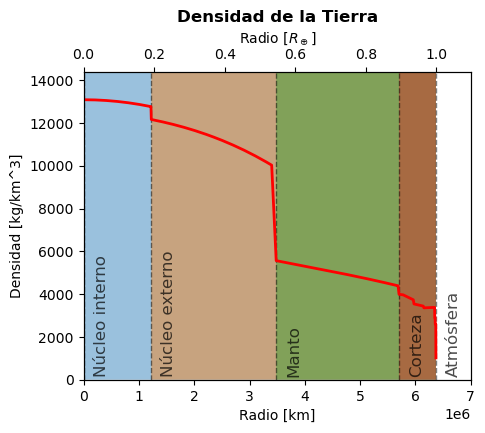

In [131]:
dens = density(radius) / km**3

_, (ax, ax_top) = plot_two_scales(dens, lw=2.0)

ax.set_ylabel("Densidad [kg/km^3]")
plt.title("Densidad de la Tierra", fontweight = "bold")

plt.savefig("figures/density.png", bbox_inches='tight')
plt.show()

$$
m = \int_0^r 4\pi r^2 \rho(r) dr
$$

In [52]:
# masa 
def mass(r):
    if r == 0: return 0 

    radius = np.linspace(0, r, int(r*2))
    f = lambda r: 4 * np.pi * r**2 * density(r)
    
    return simps(f(radius), radius)

masses = [mass(r) for r in radius]
mass = interp1d(radius, masses, kind='linear')

masses_ = mass(radius)

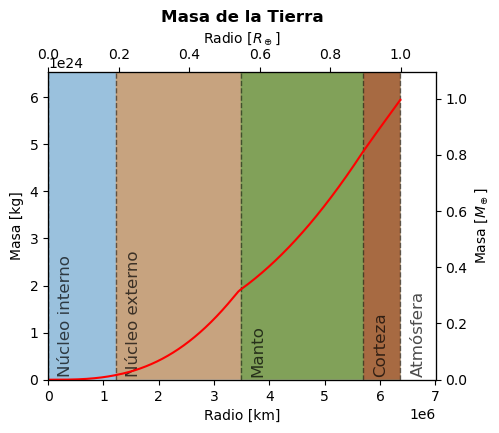

In [132]:
_, (ax, ax_top, ax_left) = plot_two_scales(masses_, scale_y = Earth.mass)

ax.set_ylabel("Masa [kg]")
ax_left.set_ylabel("Masa [$M_\oplus$]")
plt.title("Masa de la Tierra", fontweight = "bold")

plt.savefig("figures/mass.png", bbox_inches='tight')
plt.show()

$$
g = \int_0^r \left(4\pi G\rho(r) - \frac{2Gm(r)}{r^3}\right) dr
$$

In [54]:
def quad_interval(f, a, b):
    size = int(b - a) + 1
    intervals = np.linspace(a, b, size)
    
    results = np.zeros(size)
    for i in range(1, size ):
        sub_quad = quad(f, intervals[i-1], intervals[i])
        results[i] = results[i-1] + sub_quad[0]
    
    return interp1d(intervals[:], results[:], kind='linear')

In [55]:
f = lambda r: 4 * np.pi * G * density(r) - 2 * G * mass(r) / r**3 if r != 0 else 0
f = np.vectorize(f)
gravity = quad_interval(f, 0, r_max)
gravity_ = gravity(radius) / km**2


/tmp/ipykernel_4832/2334937174.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  sub_quad = quad(f, intervals[i-1], intervals[i])


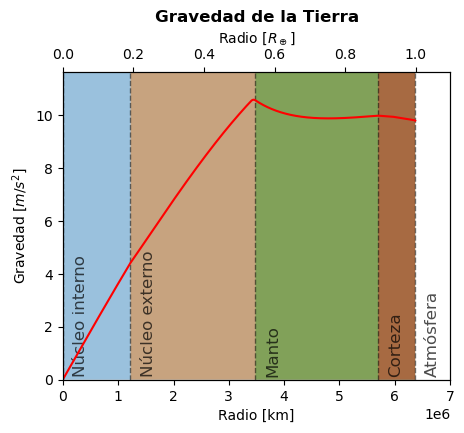

In [133]:
# plt.plot(radius , g(radius))
_, (ax, ax_top) = plot_two_scales(gravity_)

ax.set_ylabel("Gravedad [$m/s^2$]")
plt.title("Gravedad de la Tierra", fontweight = "bold")

plt.savefig("figures/gravity.png", bbox_inches='tight')
plt.show()

In [57]:
gravity_[-1] 

9.790822389568923

$$
    P= \int_R^r -\rho(r)g(r) dr
$$

In [58]:
f = lambda r: - density(r) * gravity(r) 
f = np.vectorize(f)
P = quad_interval(f, 0, r_max)
pressure = P(radius) / km 
pressure = pressure + abs(min(pressure))


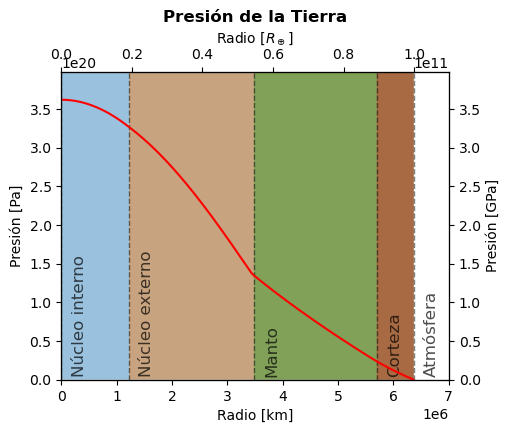

In [134]:
_, (ax, ax_top, ax_left) = plot_two_scales(pressure, scale_y = 1e9)
ax.set_ylabel("Presión [Pa]")
ax_left.set_ylabel("Presión [GPa]")
plt.title("Presión de la Tierra", fontweight = "bold")

plt.savefig("figures/pressure.png", bbox_inches='tight')
plt.show()

In [60]:
P(r_max)

array(-3.61747287e+23)

In [29]:
# Tomemos los valores hallados para los jump_indices
densities_jp = dens[jump_indices[1:]]
masses_jp = masses_[jump_indices[1:]]
gravities_jp = gravity_[jump_indices[1:]]
pressures_jp = pressure[jump_indices[1:]]

# Formateamos los valores
densities_jp = [cientific_notation(d) for d in densities_jp]
masses_jp = [cientific_notation(m) for m in masses_jp]
gravities_jp = [cientific_notation(g) for g in gravities_jp]
pressures_jp = [cientific_notation(p) for p in pressures_jp]

# Escribimos como linea de latex
densities_jp = " & ".join(densities_jp)
masses_jp = " & ".join(masses_jp)
gravities_jp = " & ".join(gravities_jp)
pressures_jp = " & ".join(pressures_jp)

text = '''
 \\begin{table}[htbp]
	\centering
	\caption{Resultados las eq. 1-4 en zonas diferenciadas del planeta}
	\label{tab:resultados_diferenciación}
	\\begin{tabular}{c|c|c|c|c}
	%   \hline
	   & \\textbf{Núcleo interno} & \\textbf{Núcleo externo} & \\textbf{Manto} & \\textbf{Corteza}\\\\
	  \hline
	  \hline
	  Densidad [$kg/m^3$] &''' + densities_jp +'''  \\\\
	  Masa [$kg$] & ''' + masses_jp +''' \\\\
	  Gravedad [$m/s^2$] & ''' + gravities_jp +''' \\\\
	  Presión [N/m]& ''' + pressures_jp +''' \\\\
	%   \hline
	\end{tabular}
\end{table}
'''

# Lo escribimos en un file .tex (Tabla1_.tex)
with open("Tabla1.tex", "w") as file:
    file.write(text)

# Punto 2

Calculemos el radio de la magnetosfera. La ecuación que nos pérmite hallar esto es:

$$
R_s = \left[ \frac{\mu_0 f_{0}^{2} M^2}{8\pi^2(mnv_{eff}^{2} + 2 n k_B T)} \right]^{1/6}
$$

In [21]:
def R_s(Body, T = 0, v = 400 * km / s, dM_dt = 5.5e9 * kg / s, f0 = 1.16):
    M = Body.M
    d = Body.a

    n = dM_dt / (4 * np.pi * (d**2) * v * m_p)

    v_orb = np.sqrt(G * Sun.mass / d**3) 
    v_eff = np.sqrt(v**2 + v_orb**2)

    up = mu_0 * f0**2 * M**2
    down = 8 * np.pi**2 * n * (m_p * v_eff**2 + 2 * k_B * T)


    return (up / down)**(1/6)

In [36]:
for planet in planets:
    print(f'{planet.name:8}: {cientific_notation(R_s(planet))} m')

Jupiter : 2.39e+09 m
Saturn  : 9.09e+08 m
Uranus  : 5.00e+08 m
Neptune : 4.62e+08 m


# Punto 3

In [9]:
v_a = 27.5 * km / s
R_a = 185 * m
rho_a = 3.5 * g / cm**3
m_a = rho_a * 4/3 * np.pi * R_a**3

E_k = (1/2) * m_a * v_a**2

print(f'v_a = {cientific_notation(v_a)} m/s')
print(f'E_k = {cientific_notation(E_k)} J')

v_a = 2.75e+04 m/s
E_k = 3.51e+19 J


In [10]:
CB = 15 * Mton # Castel Bravo

E_k_Mtones = E_k / Mton
E_k_erg = E_k / ergio
E_k_CB = E_k / CB

print(f'La energía cinética de Apophis (en varias unidades), es:')
print(f'\tE_k = {cientific_notation(E_k)} J')
print(f'\tE_k = {cientific_notation(E_k_Mtones)} Mton')
print(f'\tE_k = {cientific_notation(E_k_erg)} erg')
print(f'\tE_k = {cientific_notation(E_k_CB)} CB (Castel-Bravo)')

La energía cinética de Apophis (en varias unidades), es:
	E_k = 3.51e+19 J
	E_k = 8.40e+03 Mton
	E_k = 3.51e+26 erg
	E_k = 5.60e+02 CB (Castel-Bravo)


In [11]:
M_R = (1/1.44) * (np.log10(E_k_erg) - 12.29)
print('En la escala de Richter, la magnitud sería:')
print(f'\tM_R = {M_R:.2f}')

En la escala de Richter, la magnitud sería:
	M_R = 9.90


Procedamos con el diámetro, siguiendo la ecuación 5.25 (pag. 180 Lissauer):
$$
D = 2 \ \rho_m ^{0.11} \rho_p^{-1/3} g_p^{-0.22} R^{0.13} E_k^{0.22} (\sin \theta)^{1/3}
$$

In [20]:
print('Densidad superficial:', dens[-1])

Densidad superficial: 1019.9999999999999


In [21]:
rho_m = rho_a
rho_p = dens[-1]
g_p = 9.8 * m / s**2
E_k = E_k

D = lambda rho_m, rho_p, g_p, R, E_k, theta: \
    2 * rho_m**0.11 * \
    rho_p**-(1/3) * \
    g_p**-0.22 * \
    E_k**0.22 * \
    R**0.13 * \
    np.sin(theta)**(1/3)

D_90 = D(rho_m, rho_p, g_p, R_a, E_k, 90 * deg)
D_40 = D(rho_m, rho_p, g_p, R_a, E_k, 40 * deg)

print(f'D_90 = {cientific_notation(D_90)} m')
print(f'D_40 = {cientific_notation(D_40)} m')

D_90 = 1.16e+04 m
D_40 = 1.00e+04 m


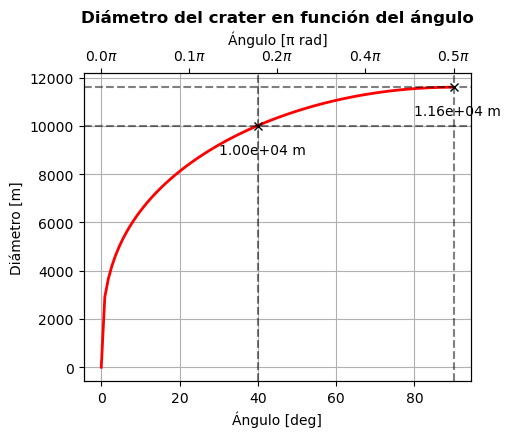

In [113]:
Dimeter_angle = np.vectorize(D, excluded=['theta'])
theta = np.linspace(0, 90, 100)
D_ = Dimeter_angle(rho_m, rho_p, g_p, R_a, E_k, theta * deg)

fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(theta, D_, lw=2, color='red')

ax.set_xlabel("Ángulo [deg]")
ax.set_ylabel("Diámetro [m]")
ax.set_title("Diámetro del crater en función del ángulo", fontweight = "bold")
ax.grid()

ax_top = ax.twiny()
ax_top.set_xlabel("Ángulo [π rad]")
ax_top.set_xlim(ax.get_xlim()) 

x_locs_deg = np.linspace(0, 90, 5)
x_locs_rad = x_locs_deg * np.pi / 180
ax_top.set_xticks(x_locs_deg)
ax_top.set_xticklabels([f"${x/180:.1f}\pi$" for x in x_locs_deg])  # Convertir ángulos a fracciones de π


# Ubicamos los valores en 90 y 40 grados
ax.text(90 - 10, D_90 -1000, f'{cientific_notation(D_90)} m', ha='left', va='center')
ax.text(40 - 10, D_40- 1000, f'{cientific_notation(D_40)} m', ha='left', va='center')

# Dos lineas que ubiquen cada punto
ax.axvline(x=90, color='k', linestyle='--', alpha=0.5)
ax.axvline(x=40, color='k', linestyle='--', alpha=0.5)

ax.axhline(y=D_90, color='k', linestyle='--', alpha=0.5)
ax.axhline(y=D_40, color='k', linestyle='--', alpha=0.5)

# plt.savefig("figures/diameter.png", bbox_inches='tight')

# marcamos los puntos
ax.plot(90, D_90, 'kx')
ax.plot(40, D_40, 'kx')

plt.savefig("figures/diameter_crater.png", bbox_inches='tight')
plt.show()

e. Distancia de formación de cráteres secundarios.

In [ ]:
v_ej = 500 * m / s

r_max_ = v_ej**2 / g_p

print(f'r_max_ = {cientific_notation(r_max_, 3)} m')

r_max = 2.551e+04 m


# Punto 4

Tomemos la ecuación usada en punto anterior:
$$
D = 2 \ \rho_m ^{0.11} \rho_p^{-1/3} g_p^{-0.22} R^{0.13} E_k^{0.22} (\sin \theta)^{1/3}
$$

Si tomamos a Eros, un asteroide del cinturón principal y consultamos ephemeris para `Apr 22 16:21:52 2024 Pasadena, USA ` obtenemos las componentes de la velocidad. Por tanto, si hallamos la norma, tendremos la velocidad de este cuerpo en au/d. 

In [ ]:
rho_Eros = 2.4 * g/cm**3

VX_Eros = -1.640089070798141E-02 
VY_Eros =  3.657007337298757E-03 
VZ_Eros = -8.820021479138533E-04

V_Eros = np.sqrt(VX_Eros**2 + VY_Eros**2 + VZ_Eros**2)
V_Eros = V_Eros * au / day
V_Eros = round(V_Eros, 0)
V_Eros

29135.0

Aplicando la ecuación:
$$
R = \left[2 \ \rho_m ^{0.11} \rho_p^{-1/3} g_p^{-0.22} D^{-1}\left(\frac{2}{3} \rho_p \pi   v^2\right)^{0.22} (\sin \theta)^{1/3}\right]^{-1/0.79} \\
$$

In [ ]:
R = lambda v, rho_m, rho_p, g_p, D, theta: (
    2 * rho_m**0.11 * \
    rho_p**-(1/3) * \
    g_p**-0.22 * \
    D**-1 * \
    (2/3 * rho_p * np.pi * v**2)**0.22 * \
    np.sin(theta)**(1/3)
)**(-1/0.70)

In [ ]:
V = V_Eros
rho_m = rho_Eros 
rho_p = 5515 * kg / m**3
g_p = 9.8 * m / s**2
D = 70 * km
theta = 90 * deg

R_cinturon = R(V, rho_m, rho_p, g_p, D, theta)
R_cinturon

9344.242325766829

Sedna `Apr 22 16:59:01 2024 Pasadena, USA`

In [ ]:
rho_Se = 2.0 * g/cm**3

VX_Sedna = -2.409714482710369E-03
VY_Sedna = 5.745274591925052E-04
VZ_Sedna = 4.400467165865281E-04

V_Sedna = np.sqrt(VX_Sedna**2 + VY_Sedna**2 + VZ_Sedna**2)
V_Sedna = V_Sedna * au / day
V_Sedna = round(V_Sedna, 0)
V_Sedna

4356.0

In [ ]:
R_Oort = R(V_Sedna, rho_Se, rho_p, g_p, D, theta)
R_Oort

31751.476556794012